In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pickle

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#### The Medley Instruments Data Set

In [3]:
df = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata.csv')

In [4]:
df

,subset,instrument,instrument_id,song_id,uuid4
0,test,clarinet,0,0,0e4371ac-1c6a-51ab-fdb7-f8abd5fbf1a3
1,test,clarinet,0,0,33383119-fd64-59c1-f596-d1a23e8a0eff
2,test,clarinet,0,0,b2b7a288-e169-5642-fced-b509c06b11fc
3,test,clarinet,0,0,151b6ee4-313a-58d9-fbcb-bab73e0d426b
4,test,clarinet,0,0,b43999d1-9b5e-557f-f9bc-1b3759659858
...,...,...,...,...,...
21566,validation,violin,7,226,fe4e8e98-6e0f-5a31-f446-99c10e0ac485
21567,validation,violin,7,226,aa606c78-9ee5-507f-f7e9-67c3530faf0f
21568,validation,violin,7,226,05e15c0a-d530-5f3e-fa82-58c55fa44993
21569,validation,violin,7,226,2dd485de-471d-5d8b-fe92-ef957dac021c


In [5]:
df.nunique()

subset               3
instrument           8
instrument_id        8
song_id            227
uuid4            21571
dtype: int64

In [6]:
df['instrument'].unique()

array(['clarinet', 'distorted electric guitar', 'female singer', 'flute',
       'piano', 'tenor saxophone', 'trumpet', 'violin'], dtype=object)

In [7]:
df.groupby(['instrument']).count()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1311,1311,1311,1311
distorted electric guitar,1854,1854,1854,1854
female singer,1744,1744,1744,1744
flute,3555,3555,3555,3555
piano,6032,6032,6032,6032
tenor saxophone,477,477,477,477
trumpet,627,627,627,627
violin,5971,5971,5971,5971


In [8]:
df.groupby(['instrument']).count().sum()

subset           21571
instrument_id    21571
song_id          21571
uuid4            21571
dtype: int64

In [9]:
df['subset'].unique()

array(['test', 'training', 'validation'], dtype=object)

In [10]:
df.groupby(['subset']).count()

,instrument,instrument_id,song_id,uuid4
subset,,,,
test,12236,12236,12236,12236
training,5841,5841,5841,5841
validation,3494,3494,3494,3494


Splitting Dataframe into Train, Validation and Test Dataframes

In [11]:
df_train = df.loc[df['subset']=='training']

##### Read train, validation and test dataframes

In [12]:
df_train = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_training.csv',index_col=0)

In [13]:
df_val = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_validation.csv',index_col=0)

In [14]:
df_test = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_test.csv',index_col=0)

In [15]:
df_train.head()

,subset,instrument,instrument_id,song_id,uuid4
12236,training,clarinet,0,139,163fd2b1-8e98-515a-f501-4742cc6d066f
12237,training,clarinet,0,139,36dcb8eb-da46-5d01-fa9d-0f715c389379
12238,training,clarinet,0,139,9f6d4046-3662-5433-fc44-98c80a428fd8
12239,training,clarinet,0,139,5ef6a0ee-a092-5d49-f64e-a3454e9ab237
12240,training,clarinet,0,139,2048e98b-77b2-5b7d-fe6a-780f399e69fe


#### Model for 4 instruments

In [16]:
# processing approach:
# define dataframe_subset_instrument
# load into librosa .wav to audio array (n,)
# save arrays with numpy

In [17]:
# starting with the Train Set: 404 elements distorted guitar

In [18]:
# begin with two instruments

In [19]:
instruments = df_train['instrument'].unique()

In [20]:
df_train.groupby(['instrument']).nunique()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1,1,5,251
distorted electric guitar,1,1,10,404
female singer,1,1,7,318
flute,1,1,3,155
piano,1,1,20,2401
tenor saxophone,1,1,2,123
trumpet,1,1,4,149
violin,1,1,10,2040


In [21]:
df_val.groupby(['instrument']).nunique()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1,1,2,328
distorted electric guitar,1,1,4,495
female singer,1,1,4,284
flute,1,1,2,233
piano,1,1,8,1022
tenor saxophone,1,1,1,29
trumpet,1,1,2,72
violin,1,1,4,1031


In [22]:
df_test.groupby(['instrument']).nunique()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1,1,18,732
distorted electric guitar,1,1,11,955
female singer,1,1,12,1142
flute,1,1,29,3167
piano,1,1,15,2609
tenor saxophone,1,1,5,325
trumpet,1,1,27,406
violin,1,1,22,2900


Understanding the data: how many songs were used per class

In [23]:
df_train.groupby(['instrument'])['song_id'].unique()

instrument
clarinet                                             [139, 140, 141, 142, 143]
distorted electric guitar    [144, 145, 146, 147, 148, 149, 150, 151, 152, ...
female singer                              [154, 155, 156, 157, 158, 159, 160]
flute                                                          [161, 162, 163]
piano                        [164, 165, 166, 167, 168, 169, 170, 171, 172, ...
tenor saxophone                                                     [184, 185]
trumpet                                                   [186, 187, 188, 189]
violin                       [190, 191, 192, 193, 194, 195, 196, 197, 198, ...
Name: song_id, dtype: object

In [24]:
df_val.groupby(['instrument'])['song_id'].unique()

instrument
clarinet                                                   [200, 201]
distorted electric guitar                        [202, 203, 204, 205]
female singer                                    [206, 207, 208, 209]
flute                                                      [210, 211]
piano                        [212, 213, 214, 215, 216, 217, 218, 219]
tenor saxophone                                                 [220]
trumpet                                                    [221, 222]
violin                                           [223, 224, 225, 226]
Name: song_id, dtype: object

In [25]:
df_test.groupby(['instrument'])['song_id'].unique()

instrument
clarinet                     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
distorted electric guitar         [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
female singer                 [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
flute                        [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 5...
piano                        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 8...
tenor saxophone                                           [85, 86, 87, 88, 89]
trumpet                      [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...
violin                       [117, 118, 119, 120, 121, 122, 123, 124, 125, ...
Name: song_id, dtype: object

In [26]:
# smaller data frames

In [27]:
df_train_clarinet = df_train.loc[df_train['instrument_id']==0].set_index('subset').reset_index()

In [28]:
df_train_guitar = df_train.loc[df_train['instrument_id']==1].set_index('subset').reset_index()

In [29]:
df_train_singer = df_train.loc[df_train['instrument_id']==2].set_index('subset').reset_index()

In [30]:
df_train_piano = df_train.loc[df_train['instrument_id']==4].set_index('subset').reset_index()

In [31]:
df_train_saxo = df_train.loc[df_train['instrument_id']==5].set_index('subset').reset_index()

In [32]:
df_train_piano.shape

(2401, 5)

In [33]:
df_train_piano.groupby(['song_id']).count()

,subset,instrument,instrument_id,uuid4
song_id,,,,
164,238,238,238,238
165,189,189,189,189
166,68,68,68,68
167,137,137,137,137
168,78,78,78,78
169,67,67,67,67
170,57,57,57,57
171,208,208,208,208
172,38,38,38,38


In [34]:
# piano split: 
# piano train, song_id 164,165,166:
238 + 189 + 68

495

In [35]:
# piano val, song_id 167, 168, 169, 170:
137 + 78 + 67 + 57 

339

In [36]:
df_train_clarinet.shape,df_train_guitar.shape, 

((251, 5), (404, 5))

In [37]:
df_train_singer.shape, df_train_saxo.shape

((318, 5), (123, 5))

In [38]:
# with the validation subset

In [39]:
df_val_clarinet = df_val.loc[df_val['instrument_id']==0].set_index('subset').reset_index()

In [40]:
df_val_guitar = df_val.loc[df_val['instrument_id']==1].set_index('subset').reset_index()

In [41]:
df_val_singer = df_val.loc[df_val['instrument_id']==2].set_index('subset').reset_index()

In [42]:
df_val_saxo = df_val.loc[df_val['instrument_id']==5].set_index('subset').reset_index()

In [43]:
# with the test subset

In [44]:
df_test_clarinet = df_test.loc[df_test['instrument_id']==0].set_index('subset').reset_index()

In [45]:
df_test_guitar = df_test.loc[df_test['instrument_id']==1].set_index('subset').reset_index()

In [46]:
df_test_singer = df_test.loc[df_test['instrument_id']==2].set_index('subset').reset_index()

In [47]:
df_test_saxo = df_test.loc[df_test['instrument_id']==5].set_index('subset').reset_index()

#### Loading signal saved in .npy numpy array files

In [48]:
filename_pre = "Medley-solos-DB"

In [49]:
def load_amp_file(filename,df):
    """input: filename, for example: amp_tr_clarinet
    output: list of amplitude vectors
    """
    # load amplitude vector
    # the corresponding dataframe must be at hand
    n_elements=(len(df))
    folderpath="../../../../../../documents/data/audio/medley/audio_arrays/"
    amp_list=[]
    with open (folderpath+filename, 'rb') as f:
        for n in range(n_elements):
            amp_1 = np.load(f)
            amp_list.append(amp_1)
    return amp_list

In [50]:
amplitude_train_clarinet = load_amp_file('amp_tr_clarinet', df_train_clarinet)

In [51]:
amplitude_train_guitar = load_amp_file('amp_tr_guitar', df_train_guitar)

In [52]:
amplitude_train_singer = load_amp_file('amp_tr_singer', df_train_singer)

In [53]:
amplitude_train_piano = load_amp_file('amp_tr_piano', df_train_piano)

In [54]:
amplitude_train_saxo = load_amp_file('amp_tr_saxo', df_train_saxo)

In [55]:
# it works!

In [56]:
# with the val dataframes

In [57]:
#load validation subset amplitude arrays

In [58]:
amplitude_val_clarinet = load_amp_file('amp_val_clarinet', df_val_clarinet)

In [59]:
amplitude_val_guitar = load_amp_file('amp_val_guitar', df_val_guitar)

In [60]:
amplitude_val_singer = load_amp_file('amp_val_singer', df_val_singer)

In [61]:
len(amplitude_val_singer)

284

In [62]:
# piano_ working only with the train set and splitting into val and test

In [63]:
#with the test dataframes

In [64]:
#load test subset amplitude arrays

In [65]:
amplitude_test_clarinet = load_amp_file('amp_test_clarinet', df_test_clarinet)

In [66]:
amplitude_test_guitar = load_amp_file('amp_test_guitar', df_test_guitar)

In [67]:
amplitude_test_singer = load_amp_file('amp_test_singer', df_test_singer)

In [68]:
#benchmark

In [69]:
len(amplitude_train_clarinet), len(amplitude_train_guitar), len(amplitude_train_singer)

(251, 404, 318)

In [70]:
# correct!

In [71]:
len(amplitude_val_clarinet), len(amplitude_val_guitar), len(amplitude_val_singer)

(328, 495, 284)

In [72]:
# correct!

In [73]:
len(amplitude_test_clarinet), len(amplitude_test_guitar), len(amplitude_test_singer)

(732, 955, 1142)

In [74]:
# correct!

In [75]:
amplitude_test_clarinet[0].shape, amplitude_test_guitar[0].shape, amplitude_test_singer[0].shape

((65536,), (65536,), (65536,))

In [76]:
# it worked!

In [77]:
# up here: second part, load data and ML

MEL SPECTROGRAM

In [78]:
def signal_to_logmel(amp_list):
    """input: list of signal arrays 1d
    output: list of melspectrogram arrays 2d"""
    logmel_list=[]
    for signal_1 in amp_list:
        logmel_1 = librosa.feature.melspectrogram(y=signal_1,sr=22050,n_fft=2048,
                                                           hop_length=512,n_mels=129)
        loglogmel_1 = librosa.power_to_db(logmel_1)
        logmel_list.append(loglogmel_1)  
    return logmel_list

In [79]:
## TRAINING SUBSET

In [80]:
mel_spectrogram_train_clarinet = signal_to_logmel(amplitude_train_clarinet)

In [81]:
mel_spectrogram_train_guitar = signal_to_logmel(amplitude_train_guitar)

In [82]:
mel_spectrogram_train_singer = signal_to_logmel(amplitude_train_singer)

In [83]:
mel_spectrogram_train_piano = signal_to_logmel(amplitude_train_piano)

In [84]:
len(mel_spectrogram_train_clarinet), len(mel_spectrogram_train_guitar),

(251, 404)

In [85]:
len(mel_spectrogram_train_singer), len(mel_spectrogram_train_piano)

(318, 2401)

In [86]:
mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_clarinet[0].shape

((129, 129), (129, 129))

In [87]:
mel_spectrogram_train_singer[0].shape, mel_spectrogram_train_piano[0].shape

((129, 129), (129, 129))

In [ ]:
# visualization

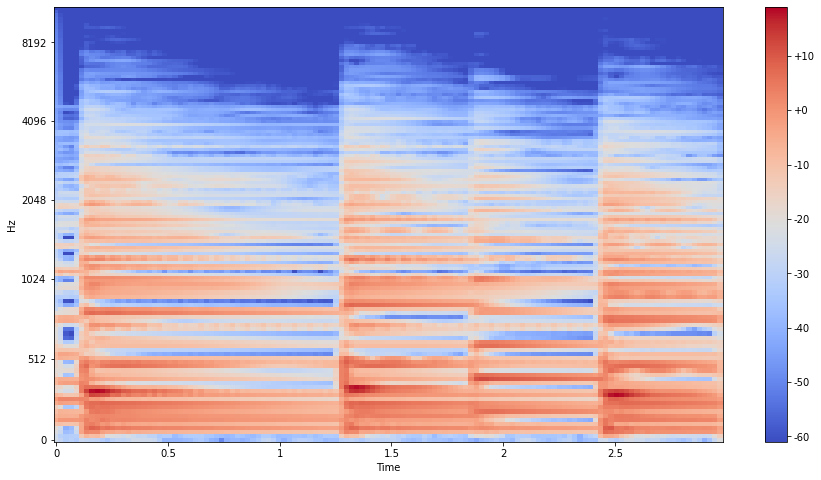

In [293]:
plt.figure(figsize=(15,8))
librosa.display.specshow(mel_spectrogram_train_piano[700],
                         x_axis='time',
                         y_axis='mel')
plt.colorbar(format="%+2.f")
plt.savefig('../data/spectrograms/tr_piano_700.png')

In [263]:
# Arrangement of the feature and target vectors X and y

In [88]:
X_tr_clarinet = np.stack(mel_spectrogram_train_clarinet,axis=0)
X_tr_clarinet.shape

(251, 129, 129)

In [89]:
X_tr_clarinet_resh = X_tr_clarinet.reshape(251,129,129,1)

In [90]:
X_tr_clarinet_resh.shape

(251, 129, 129, 1)

In [91]:
y_tr_clarinet = np.zeros((251,1))

In [92]:
X_tr_guitar = np.stack(mel_spectrogram_train_guitar,axis=0)
X_tr_guitar.shape

(404, 129, 129)

In [93]:
X_tr_guitar_resh = X_tr_guitar.reshape(404,129,129,1)

In [94]:
y_tr_guitar = np.ones((404,1))

In [95]:
X_tr_singer = np.stack(mel_spectrogram_train_singer,axis=0)
X_tr_singer.shape

(318, 129, 129)

In [96]:
X_tr_singer_resh = X_tr_singer.reshape(318,129,129,-1)

In [97]:
X_tr_singer_resh.shape

(318, 129, 129, 1)

In [98]:
y_tr_singer = np.ones((318,1))*2

In [99]:
# train_piano set: 2401 samples
# we will use 500 for X_train, 500 for validation
# the rest 1401 for test

In [100]:
X_tr_piano = np.stack(mel_spectrogram_train_piano[0:495])
X_tr_piano.shape

(495, 129, 129)

In [101]:
X_tr_piano_resh = X_tr_piano.reshape(495,129,129,1)

In [102]:
X_tr_piano_resh.shape

(495, 129, 129, 1)

In [103]:
y_tr_piano = np.ones((495,1))*3

In [104]:
# X_train shape (number wav files, f domain, t domain, 1)
# number wav clarinet + guitar + singer + piano:
(251 + 404 + 318 + 495, 129, 129)

(1468, 129, 129)

In [105]:
X_train = np.concatenate([X_tr_clarinet_resh, X_tr_guitar_resh, X_tr_singer_resh, X_tr_piano_resh])

In [106]:
X_train.shape

(1468, 129, 129, 1)

In [107]:
y_train = np.concatenate([y_tr_clarinet, y_tr_guitar, y_tr_singer,y_tr_piano])

In [108]:
y_train.shape

(1468, 1)

In [109]:
# One hot encode the labels:
# Keep a copy of y test as the actual number labels:
y_train_true = y_train.copy()

In [110]:
y_train = to_categorical(y_train)

In [111]:
y_train.shape

(1468, 4)

In [112]:
## VALIDATION SUBSET

In [113]:
mel_spectrogram_val_clarinet = signal_to_logmel(amplitude_val_clarinet)

In [114]:
mel_spectrogram_val_guitar = signal_to_logmel(amplitude_val_guitar)

In [115]:
mel_spectrogram_val_singer = signal_to_logmel(amplitude_val_singer)

In [116]:
mel_spectrogram_val_piano = mel_spectrogram_train_piano[495:834]

In [117]:
len(mel_spectrogram_val_clarinet), len(mel_spectrogram_val_guitar)

(328, 495)

In [118]:
len(mel_spectrogram_val_singer), len(mel_spectrogram_val_piano)

(284, 339)

In [119]:
mel_spectrogram_train_clarinet[0].shape, mel_spectrogram_train_clarinet[0].shape


((129, 129), (129, 129))

In [120]:
mel_spectrogram_train_singer[0].shape, mel_spectrogram_val_piano[0].shape

((129, 129), (129, 129))

In [121]:
# X_val, y val

In [122]:
# clarinet

In [123]:
X_val_clarinet = np.stack(mel_spectrogram_val_clarinet,axis=0)
X_val_clarinet.shape

(328, 129, 129)

In [124]:
X_val_clarinet_resh = X_val_clarinet.reshape(328,129,129,1)

In [125]:
X_val_clarinet_resh.shape

(328, 129, 129, 1)

In [126]:
y_val_clarinet = np.zeros((328,1))

In [127]:
# guitar

In [128]:
X_val_guitar = np.stack(mel_spectrogram_val_guitar,axis=0)
X_val_guitar.shape

(495, 129, 129)

In [129]:
X_val_guitar_resh = X_val_guitar.reshape(495,129,129,1)

In [130]:
X_val_guitar_resh.shape

(495, 129, 129, 1)

In [131]:
y_val_guitar = np.ones((495,1))

In [132]:
# singer

In [133]:
X_val_singer = np.stack(mel_spectrogram_val_singer,axis=0)
X_val_singer.shape

(284, 129, 129)

In [134]:
X_val_singer_resh = X_val_singer.reshape(284,129,129,-1)

In [135]:
X_val_singer_resh.shape

(284, 129, 129, 1)

In [136]:
y_val_singer = np.ones((284,1))*2

In [137]:
# piano

In [138]:
X_val_piano = np.stack(mel_spectrogram_val_piano,axis=0)
X_val_piano.shape

(339, 129, 129)

In [139]:
X_val_piano_resh = X_val_piano.reshape(339,129,129,1)

In [140]:
X_val_piano_resh.shape

(339, 129, 129, 1)

In [141]:
y_val_piano = np.ones((339,1))*3

In [142]:
# X_val shape (number wav files, f domain, t domain, 1)
# number wav guitar + singer:
(328 + 495 + 284 + 339, 129, 129)

(1446, 129, 129)

In [143]:
X_val = np.concatenate([X_val_clarinet_resh, X_val_guitar_resh, X_val_singer_resh,X_val_piano_resh])

In [144]:
X_val.shape

(1446, 129, 129, 1)

In [145]:
y_val = np.concatenate([y_val_clarinet, y_val_guitar, y_val_singer,y_val_piano])

In [146]:
y_val_clarinet[327][0]

0.0

In [147]:
y_val_guitar[394][0]

1.0

In [148]:
y_val_singer[283][0]

2.0

In [149]:
y_val_piano[338,0]

3.0

In [150]:
y_val.shape

(1446, 1)

In [151]:
# One hot encode the labels:
# Keep a copy of y test as the actual number labels:
y_val_true = y_val.copy()

In [152]:
y_val = to_categorical(y_val)

In [153]:
y_val.shape

(1446, 4)

In [154]:
y_val

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [155]:
y_val[327:329,0]

array([1., 0.], dtype=float32)

In [156]:
y_val[327:329,1]

array([0., 1.], dtype=float32)

In [157]:
# the same needs to be done with the test 

MODELLING

In [158]:
# general functions and plots

In [159]:
def plot_accuracy(history):    
    # Plot accuracy curve
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()

In [160]:
def plot_loss(history):
# Plot loss
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

In [161]:
# Early stopping:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=3, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    mode='auto'
)

In [162]:
# Model

In [323]:
#model 00: relu, relu

In [330]:
# model 00
# Clear session and build above model:
K.clear_session()
model_00 = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),

    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(4,activation= 'softmax')   
])

In [325]:
# Check the summary:
model_00.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1440100   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [326]:
# compile model
model_00.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [327]:
X_train.shape, y_train.shape

((1468, 129, 129, 1), (1468, 1))

In [328]:
X_val.shape, y_val.shape

((1446, 129, 129, 1), (1446, 4))

In [ ]:
# fit the model
history_00 = model_00.fit(X_train,y_train,batch_size=400, epochs=35,validation_data=(X_val,y_val))

In [ ]:
model_00.save('../data/models/three_instruments/2conv_00.h5')

In [ ]:
with open('../data/models/three_instruments/2conv_00_hist.h5', 'wb') as file_pi:
    pickle.dump(history_00.history, file_pi)

In [ ]:
# history_2B_loaded = pickle.load(open('../data/models/two_instruments/3conv2d_bn_dout_hist.h5',"rb"))

In [ ]:
# examine the model

In [ ]:
history_00.history;

In [ ]:
plot_accuracy(history_00)

In [ ]:
plot_loss(history_00)

In [ ]:
pd.DataFrame(history_00.history).plot()

In [163]:
# model 0a: relu / tanh

In [164]:
# model 0a
# Clear session and build above model:
K.clear_session()
model_0a = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),

    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(4,activation= 'softmax')   
])

In [165]:
# Check the summary:
model_0a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1440100   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4

In [166]:
# compile model
model_0a.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [167]:
# fit the model
history_0a = model_0a.fit(X_train,y_train,batch_size=722,epochs=40,validation_data=(X_val,y_val),)

Epoch 1/40
3/3 [==============================] - 26s 5s/step - loss: 16.7338 - accuracy: 0.2738 - val_loss: 7.3993 - val_accuracy: 0.2642
Epoch 2/40
3/3 [==============================] - 17s 5s/step - loss: 5.6524 - accuracy: 0.2316 - val_loss: 2.8961 - val_accuracy: 0.4848
Epoch 3/40
3/3 [==============================] - 20s 6s/step - loss: 2.6462 - accuracy: 0.4680 - val_loss: 2.1882 - val_accuracy: 0.5539
Epoch 4/40
3/3 [==============================] - 17s 5s/step - loss: 1.3660 - accuracy: 0.6437 - val_loss: 0.9291 - val_accuracy: 0.6715
Epoch 5/40
3/3 [==============================] - 20s 7s/step - loss: 0.8449 - accuracy: 0.7446 - val_loss: 0.9445 - val_accuracy: 0.6169
Epoch 6/40
3/3 [==============================] - 21s 6s/step - loss: 0.6837 - accuracy: 0.7568 - val_loss: 1.0053 - val_accuracy: 0.6763
Epoch 7/40
3/3 [==============================] - 20s 7s/step - loss: 0.5503 - accuracy: 0.8011 - val_loss: 1.7501 - val_accuracy: 0.5712
Epoch 8/40
3/3 [=================

In [171]:
model_0a.save('../data/models/four_instruments/2conv_0a.h5')

In [172]:
# model_0a_loaded = keras.models.load_model('../data/models/four_instruments/2conv_0a.h5')

In [173]:
# save history

In [174]:
df_history_0a = pd.DataFrame(history_0a.history)
df_history_0a.to_csv('../data/models/four_instruments/2conv_0a_hist.csv')

In [175]:
df_history_0a = pd.read_csv('../data/models/four_instruments/2conv_0a_hist.csv')

In [177]:
df_history_0a.tail(3);

In [178]:
# examine the model

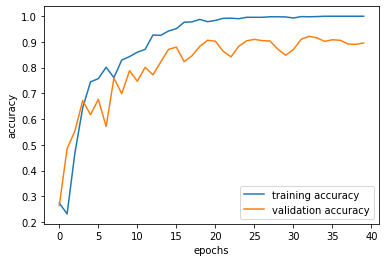

In [179]:
plot_accuracy(history_0a)
plt.savefig('../data/models/four_instruments/2conv_0a_acc.png')

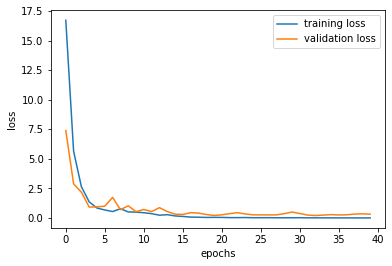

In [180]:
plot_loss(history_0a)
plt.savefig('../data/models/four_instruments/2conv_0a_loss.png')

In [181]:
history_0a.history;

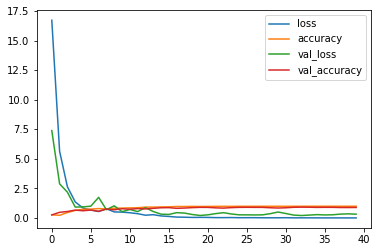

In [182]:
pd.DataFrame(history_0a.history).plot()
plt.savefig('../data/models/four_instruments/2conv_0a_acc_loss.png')

In [183]:
#model 0b: tanh / tanh

In [ ]:
# model 00b:
# Clear session and build above model:
K.clear_session()
model = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'tanh' ,input_shape = (129,129,1)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),

    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(2,activation= 'sigmoid')   
])

In [ ]:
# Check the summary:
model.summary()

In [ ]:
# compile model
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# fit the model
history = model.fit(X_train,y_train,batch_size=400, epochs=35,validation_data=(X_val,y_val))

In [ ]:
# examine the model

In [ ]:
history.history;

In [ ]:
plot_accuracy(history)

In [ ]:
plot_loss(history)

In [ ]:
pd.DataFrame(history.history).plot()

In [184]:
# model 01:
# 2nd Conv2D with tanh
# bath norm after 1st Conv2D

In [192]:
# model 01
# Clear session and build above model:
K.clear_session()

model_01 = Sequential([
    Conv2D( filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu', input_shape = (129,129,1)),
    Dropout(0.1),
    ##BatchNormalization(),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    #Dropout(0.1),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(4,activation= 'softmax')   
])

In [193]:
# Check the summary:
model_01.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [194]:
# compile model
model_01.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [195]:
# fit the model
history_01 = model_01.fit(X_train,y_train,batch_size=750, epochs=40,validation_data=(X_val,y_val))

Epoch 1/40
2/2 [==============================] - 25s 12s/step - loss: 6.7913 - accuracy: 0.2016 - val_loss: 26.4287 - val_accuracy: 0.3423
Epoch 2/40
2/2 [==============================] - 21s 12s/step - loss: 27.5197 - accuracy: 0.3086 - val_loss: 23.6880 - val_accuracy: 0.2344
Epoch 3/40
2/2 [==============================] - 23s 13s/step - loss: 16.3080 - accuracy: 0.3658 - val_loss: 7.2594 - val_accuracy: 0.3416
Epoch 4/40
2/2 [==============================] - 22s 13s/step - loss: 4.5351 - accuracy: 0.2841 - val_loss: 2.9817 - val_accuracy: 0.2289
Epoch 5/40
2/2 [==============================] - 24s 13s/step - loss: 2.9555 - accuracy: 0.2289 - val_loss: 2.7661 - val_accuracy: 0.2400
Epoch 6/40
2/2 [==============================] - 23s 13s/step - loss: 1.8345 - accuracy: 0.3569 - val_loss: 1.9486 - val_accuracy: 0.4461
Epoch 7/40
2/2 [==============================] - 23s 13s/step - loss: 1.4789 - accuracy: 0.4169 - val_loss: 2.3554 - val_accuracy: 0.3548
Epoch 8/40
2/2 [=======

In [196]:
model_01.save('../data/models/four_instruments/2conv_01.h5')

In [200]:
# model_01_loaded = keras.models.load_model('../data/models/four_instruments/2conv_01.h5')

In [201]:
# save history

In [202]:
df_history_01 = pd.DataFrame(history_01.history)
df_history_01.to_csv('../data/models/four_instruments/2conv_01_hist.csv')

In [203]:
df_history_01 = pd.read_csv('../data/models/four_instruments/2conv_01_hist.csv')

In [204]:
df_history_01.tail(3);

In [205]:
# examine the model

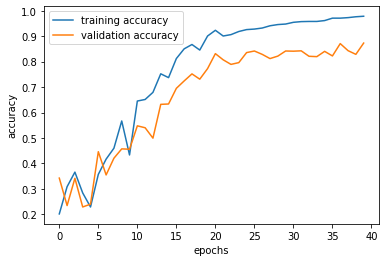

In [206]:
plot_accuracy(history_01)
plt.savefig('../data/models/four_instruments/2conv_01_acc.png')

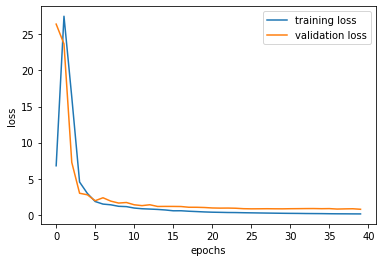

In [207]:
plot_loss(history_01)
plt.savefig('../data/models/four_instruments/2conv_01_loss.png')

In [181]:
history_01.history;

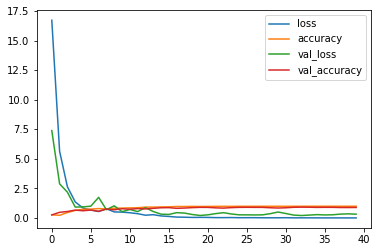

In [182]:
pd.DataFrame(history_0a.history).plot()
plt.savefig('../data/models/four_instruments/2conv_01_acc_loss.png')

In [215]:
# model 2
# 3 Conv2D

In [220]:
# model 02
# Clear session and build above model:
K.clear_session()

model_02 = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(4,activation= 'softmax')   
])

In [221]:
# Check the summary:
model_02.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [222]:
# compile model
model_02.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [224]:
# fit the model
history_02 = model_02.fit(X_train,y_train,batch_size=600, epochs=50,validation_data=(X_val,y_val))

Epoch 1/40
3/3 [==============================] - 19s 7s/step - loss: 1.3040 - accuracy: 0.4155 - val_loss: 0.9774 - val_accuracy: 0.5636
Epoch 2/40
3/3 [==============================] - 19s 6s/step - loss: 0.9738 - accuracy: 0.5729 - val_loss: 0.7133 - val_accuracy: 0.7026
Epoch 3/40
3/3 [==============================] - 16s 6s/step - loss: 0.6746 - accuracy: 0.7228 - val_loss: 0.5985 - val_accuracy: 0.7732
Epoch 4/40
3/3 [==============================] - 16s 6s/step - loss: 0.4630 - accuracy: 0.8719 - val_loss: 0.4461 - val_accuracy: 0.8499
Epoch 5/40
3/3 [==============================] - 16s 6s/step - loss: 0.3378 - accuracy: 0.8937 - val_loss: 0.3515 - val_accuracy: 0.8686
Epoch 6/40
3/3 [==============================] - 16s 5s/step - loss: 0.2492 - accuracy: 0.9346 - val_loss: 0.3243 - val_accuracy: 0.8776
Epoch 7/40
3/3 [==============================] - 16s 5s/step - loss: 0.1848 - accuracy: 0.9482 - val_loss: 0.3118 - val_accuracy: 0.8762
Epoch 8/40
3/3 [==================

In [257]:
model_02.save('../data/models/four_instruments/3conv_02.h5')

In [258]:
# examine the model

In [259]:
history_02.history;

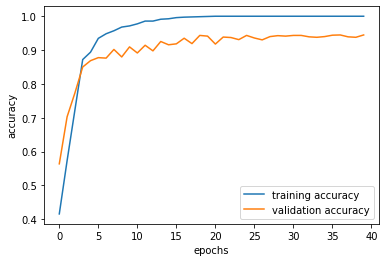

In [260]:
plot_accuracy(history_02)
plt.savefig('../data/models/four_instruments/2conv_02_acc.png')

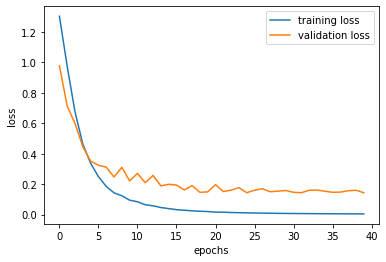

In [261]:
plot_loss(history_02)
plt.savefig('../data/models/four_instruments/2conv_02_loss.png')

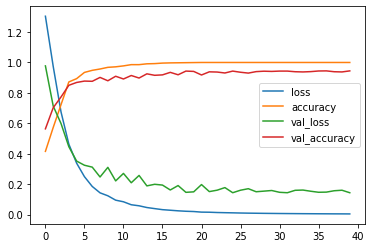

In [262]:
pd.DataFrame(history_02.history).plot()
plt.savefig('../data/models/four_instruments/2conv_02_acc_loss.png')

In [253]:
model_02.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [225]:
# model 2BD
# 3 Conv2D batch

In [232]:
# model 2BD
# Clear session and build above model:
K.clear_session()

model_2BD = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (129,129,1)),
    
    #BatchNormalization(),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    #Dropout(0.1),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    #BatchNormalization(),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Dropout(0.1),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    #BatchNormalization(),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    #Dropout(0.1),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.1),
    Dense(4,activation= 'softmax')   
])

In [233]:
# Check the summary:
model_2BD.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0

In [234]:
# compile model
model_2BD.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [236]:
# fit the model
history_2BD = model_2BD.fit(X_train,y_train,batch_size=700, epochs=60,validation_data=(X_val,y_val))

Epoch 1/60
3/3 [==============================] - 16s 5s/step - loss: 0.7385 - accuracy: 0.3059 - val_loss: 0.5933 - val_accuracy: 0.4716
Epoch 2/60
3/3 [==============================] - 16s 5s/step - loss: 0.6201 - accuracy: 0.3202 - val_loss: 0.5027 - val_accuracy: 0.4876
Epoch 3/60
3/3 [==============================] - 18s 6s/step - loss: 0.5031 - accuracy: 0.4305 - val_loss: 0.4806 - val_accuracy: 0.3485
Epoch 4/60
3/3 [==============================] - 17s 5s/step - loss: 0.4848 - accuracy: 0.3590 - val_loss: 0.4127 - val_accuracy: 0.6867
Epoch 5/60
3/3 [==============================] - 16s 5s/step - loss: 0.4242 - accuracy: 0.5783 - val_loss: 0.3491 - val_accuracy: 0.7759
Epoch 6/60
3/3 [==============================] - 17s 5s/step - loss: 0.3848 - accuracy: 0.7514 - val_loss: 0.3488 - val_accuracy: 0.7324
Epoch 7/60
3/3 [==============================] - 18s 5s/step - loss: 0.3508 - accuracy: 0.7091 - val_loss: 0.3241 - val_accuracy: 0.8043
Epoch 8/60
3/3 [==================

3/3 [==============================] - 17s 5s/step - loss: 0.0053 - accuracy: 0.9993 - val_loss: 0.0880 - val_accuracy: 0.9405


In [237]:
model_2BD.save('../data/models/two_instruments/3conv_2BD.h5')

In [238]:
#model_2BB_loaded = keras.models.load_model('../data/models/two_instruments/3conv_2BD.h5')

In [239]:
#with open('../data/models/two_instruments/3conv2d_2B_hist.h5', 'wb') as file_pi:
 #       pickle.dump(history_2B.history, file_pi)

In [240]:
#history_2BB_loaded = pickle.load(open('../data/models/two_instruments/3conv2d_2B_hist.h5',"rb"))

In [241]:
df_history_2BD = pd.DataFrame(history_2BD.history)
df_history_2BD.to_csv('../data/models/two_instruments/3conv_2BD_hist.csv')

In [242]:
history_2BD.history

{'loss': [0.7384822964668274,
  0.6200864911079407,
  0.5031455755233765,
  0.48477301001548767,
  0.42416200041770935,
  0.38477739691734314,
  0.35084056854248047,
  0.30390265583992004,
  0.28061819076538086,
  0.2604747712612152,
  0.22708497941493988,
  0.20330440998077393,
  0.18016435205936432,
  0.1640067845582962,
  0.14666128158569336,
  0.1306917518377304,
  0.11903204768896103,
  0.10370530188083649,
  0.1006060540676117,
  0.08750603348016739,
  0.07920322567224503,
  0.07056161016225815,
  0.06602956354618073,
  0.060248807072639465,
  0.053975336253643036,
  0.04912557825446129,
  0.05106088146567345,
  0.04574775695800781,
  0.04088379815220833,
  0.03476405888795853,
  0.031136058270931244,
  0.028341608121991158,
  0.025745222344994545,
  0.023584851995110512,
  0.021379675716161728,
  0.019602207466959953,
  0.018082473427057266,
  0.017670419067144394,
  0.016014082357287407,
  0.014386634342372417,
  0.01348145678639412,
  0.013292960822582245,
  0.0116756465286016

In [243]:
# examine the model

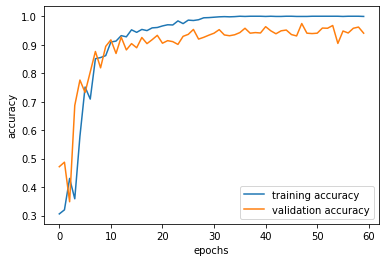

In [244]:
plot_accuracy(history_2BD)
plt.savefig('../data/models/two_instruments/3conv_2BD_acc.png')

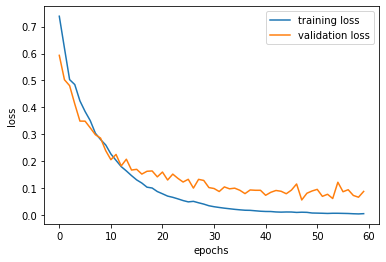

In [245]:
plot_loss(history_2BD)
plt.savefig('../data/models/two_instruments/3conv_2BD_acc.png')

<AxesSubplot:>

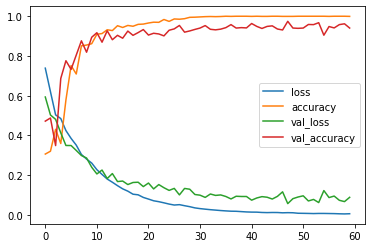

In [247]:
pd.DataFrame(history_2BD.history).plot()

In [ ]:
# predictions:

In [ ]:
y_val.shape

In [ ]:
X_val[0].reshape(1,129,129,1).shape

In [ ]:
y_pred = model_2B.predict(X_val[1].reshape(1,129,129,1))

In [ ]:
y_pred

In [ ]:
X_test_guitar, X_test_singer, X_clarinet

In [208]:
# model 03: more filters

In [209]:
# model 03
# Clear session and build above model:
K.clear_session()

model_03 = Sequential([
    Conv2D( filters = 20, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu', input_shape = (129,129,1)),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Conv2D(filters = 20, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'tanh'),
    
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(4,activation= 'softmax')   
])

In [211]:
# Check the summary:
model_03.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 20)      200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 20)        3620      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18000)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1800100   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4

In [213]:
# compile model
model_03.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# fit the model
history_03 = model_03.fit(X_train,y_train,batch_size=722, epochs=40,validation_data=(X_val,y_val))

In [ ]:
# examine the model

In [ ]:
history.history;

In [ ]:
plot_accuracy(history)

In [ ]:
plot_loss(history)

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
# confusion matrix

#### Pre trained CNN

In [ ]:
# bonus: shuffling an array

In [ ]:
abc = np.array([[1,2],[3,4],[5,6],[7,8],[0,9]])

In [ ]:
abc

In [ ]:
abc.shape

In [ ]:
np.random.shuffle(abc)
abc

In [ ]:
np.arange(10)